# 第6讲：检索更准：RAG召回效果优化的底层逻辑与技巧
> 在前面的课程中我们学习到 RAG（Retrieval-Augmented Generation）系统是一种结合检索和生成两个核心组件实现基于外部知识源回答用户查询的智能系统，可以在一定程度上克服大模型幻觉问题在特定领域问答任务上给出与上下文相关的答案。RAG 的基本思想是先通过检索模块从大量文档中找到与用户问题相关的上下文，然后将这些信息提供给生成模型，以生成更加精准和可靠的答案。尽管 RAG 系统的基础架构较为清晰，并且已有许多工具和框架可以帮助开发者快速搭建，但要真正实现高精度、高效率的输出仍然充满挑战。一个优秀的 RAG 系统不仅仅是简单地将文档存入向量数据库再叠加一个大语言模型，需要针对检索和生成的不同环节进行深度优化，确保信息检索的准确性和生成内容的可靠性。本章主要探讨如何提升 RAG 的回答效果相关的策略。

本篇文章围绕 RAG 系统的效果评测方法展开，重点介绍如何评估检索与生成组件的性能与提升检索组件效果的相关策略。首先，我们将深入探讨检索组件的评估标准，包括召回率（Recall）和上下文相关性（Context Relevance），以衡量检索的覆盖度和精准度。接下来，我们会介绍生成组件的评估指标，例如忠诚度（Faithfulness）和答案相关性（Answer Relevance），用于判断生成内容是否准确、可信，并与检索到的内容紧密相关。在介绍完核心评测指标后，我们将进一步探讨提升检索组件效果的常用方法，包括查询重写策略、优化的检索策略以及重排序策略，构建更精准的 RAG 检索组件。

如果您希望深入了解如何优化生成组件以进一步提升答案的质量，可以跳转至选修 3 进行学习，在那里我们会介绍更多针对语言模型的优化策略，如指令微调、知识注入以及生成过滤等方法。通过系统性的评估与优化，您将能够构建一个更加精准、高效的 RAG 系统，为用户提供更具价值的答案。

## RAG效果评测

RAG系统结合检索与生成两个组件实现由外部知识源查找相关信息从而对抗大模型的幻觉问题生成符合用户查询上下文的响应。其中检索组件从大量外部数据中召回与用户查询相关的少部分文档，然后将这些文档作为上下文输入给生成组件由其生成答案。因此在一个简单的RAG系统中，我们可以评估以下几个环节，通过提升这几个环节输出的指标，最终实现提升RAG系统输出的目标：

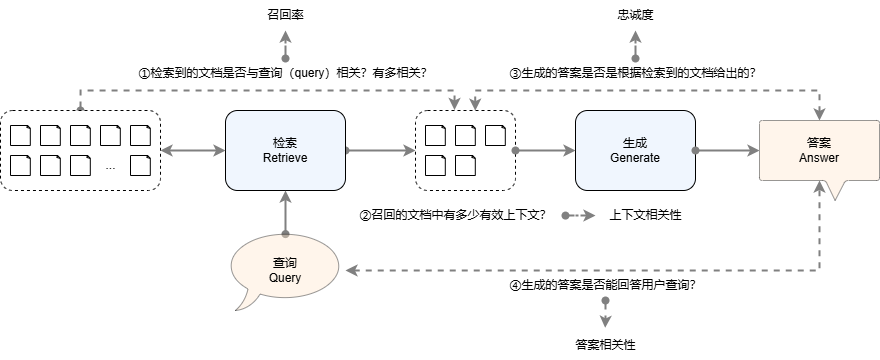
图1：RAG评测维度和相关方法

（1）检索组件从大量外部数据源召回的文档是否与用户查询相关，有多相关？这一环节决定了生成组件获得的上下文与用户查询相关与否，换言之，系统能否生成符合用户查询上下文的答案取决于检索组件召回的文档与查询的相关度。我们通常通过召回率这一指标衡量检索组件召回文档与用户查询的相关度，召回率越高，生成组件获得的相关上下文越多，越有可能生成与用户查询高度相关的答案，而当召回率很低时，系统效果将近似于由生成组件直接回答用户问题。

（2）检索组件召回的文档中有效的上下文有多少？通常来说检索组件召回的文档长度是较大的，此时无法保证整篇文档中的所有信息都是与查询相关的，此时这些噪声可能会导致最终答案与目标答案相差较大。评估这一环节通常选用RAGAS框架中的上下文相关性（Context Relevance），计算与查询相关的上下文比例。

（3）生成组件给出的答案是否与检索组件提供的上下文相关？生成组件的能力决定了当检索组件提供了与用户查询高度相关的上下文时生成组件能否充分利用这些信息给出符合查询上下文的答案。目前可选择的大语言模型多种多样，如何选择最适合当前系统的生成组件首先需要衡量的就是这一能力。RAGAS 框架中的忠诚度（Faithfulness）是衡量大模型是否能生成与提供上下文高度相关的重要指标。

（4）系统最终答案是否与用户查询相关？提升RAG系统答案与用户查询之间的相关度是RAG系统的最终优化目标，我们通常通过RAGAS框架中的答案相关性（Answer Relevance）评估这一点。

一个理想的RAG系统应当在检索组件上具备较高的召回率和上下文相关性分数，在生成组件方面具备较高的忠诚度和答案相关性分数。

### 检索组件评估

在RAG实践中通常通过查看查询与召回之间的结果对检索组件的质量进行评估，常用评估指标有召回率（recall）和上下文相关性（context relevance）。其中召回率指的是系统从文档库中召回了多少与查询相关的文档，衡量系统的查全率；而上下文相关性则衡量召回文档中与查询相关的句子在总句子数中的占比。二者取值均为越高越好，取值越高说明检索组件提供的上下文与用户查询相关度越高，有助于系统输出与问题高度相关的答案。

#### 1. 召回率

召回率是检索出的相关文档数和文档库中所有相关文档数的比例，衡量检索器的查全率，即所有相关文档中有多少被检索出来了。召回率的计算公式如下：

$$
Recall = \frac{TP}{TP + FN}
$$


其中TP（True Positive）代表的是真实类别为正例，且结果也是正例的样本，即检索结果中与查询相关的文档数；FN（False Negative）代表的是真实类别为正例，但结果被识别为负例的样本，即没有被召回的相关文档。例如文档库中有5篇文档是与当前查询相关的，而检索组件检索只检索到了3篇，则召回率为3/5=0.6，实际应用中，召回率越高，对生成组件提供的相关证据就越多，有助于提升RAG的总体效果。

#### 2. 上下文相关性

上述召回率是针对文档块级别的评估方法，除此之外可以构造更加细粒度的评估方法对检索器进行评估。RAGAS是一种高级RAG评估体系[参考文献1]，此处简单介绍其提出的上下文相关性（context relevance）。

上下文相关性在检索到的文档上提取与查询相关的句子，然后在句子级别计算精度，其计算方式可表达为：

$$
CR=\frac{与查询相关的句子总数}{召回文档中的句子总数}
$$

上下文相关性主要衡量的是检索组件给出的上下文中与查询相关的句子的占比，这个值越高，说明该段上下文包含的有效参考内容越多，有利于生成组件从中提取关键证据。例如文档库中有5篇文档是与当前查询相关的，而检索组件检索只检索到了3篇，这3篇文档一共包含10个句子，与查询相关的句子只有4句，那CR值就是4/10=0.4.

### 生成组件评估

RAG的生成组件主要是通过检索组件给出的文档进行答案生成，主要从忠诚度（faithfulness）和答案相关性（answer relevance）两个维度进行评估。其中忠诚度评估的是生成组件的答案与检索组件给出的上下文相关，对对抗大模型幻觉至关重要，而答案相关性则需要评估生成组件给出的答案是否能够准确响应问题。

#### 1. 忠诚度

当生成组件给出的答案是可以在上下文中找到出处的，则称答案 a 是忠诚于上下文 c 的。为了构造客观计算指标，通常会按照如下方式流程进行：

（1）利用LLM从答案中抽取一系列语句，这一步的目的是将长难句精简为多个精简准确的断言 S（或命题）；

（2）将上一步提取的断言 S 和检索器给出的上下文一同输入给LLM，让LLM推断这些断言是否来自检索上下文；

（3）计算最终得分

$$F=\frac{|V|}{|S|}$$

其中|V|是来源于检索上下文的断言个数，|S|是所有断言个数。该值越大，说明该系统的忠诚度越高。下面一起看一个例子：

> Query：地球上最高的山是哪座？ Context（上下文）：珠穆朗玛峰（Mount Everest）是地球上最高的山峰，海拔约 8848.86 米，位于尼泊尔和中国西藏的边界。 高度忠诚的答案：地球上最高的山是珠穆朗玛峰，海拔 8848.86 米。 低忠诚度答案：地球上最高的山是珠穆朗玛峰，海拔 5895 米。
> 
> 我们以其中的低忠诚度答案为例，构造断言
> 
> 断言1：地球上最高的山是珠穆朗玛峰。
> 
> 断言2：地球上最高的山海拔是5895米。
> 
> 此时大模型应输出的答案为：
> 
> 断言1：是。
> 
> 断言2：不是。

因此针对这个问题的答案，该系统的忠诚度得分为0.5。

#### 2. 答案相关性

答案相关性（Answer Relevance，AR）衡量的是对用户查询生成的答案的质量，即答案与用户问题的相关性，检查答案是否完整，是否包含冗余信息。为了评估这一点，通过大模型生成N个问题，如果提供的答案与原始问题相关，则问题应该与原始问题高度相似。其流程可分解为：

（1）给定答案，让LLM生成该答案可能对应的N个问题，N一般在3到4之间；

（2）对所有可能的问题进行向量嵌入；

（3）计算潜在问题向量 qi 和原始查询向量 q 的相似度：

$$
AR = \frac{1}{N} \sum_{i=1}^N \text{sim}(q, q_i)
$$


其中sim可以是余弦相似度等向量相似度计算方法。同样针对”地球上最高的山是珠穆朗玛峰，海拔 8848.86 米“的答案，利用大模型生成答案，得到如下三个可能的问题：

问题1：地球上最高的山是哪座？

问题2：珠穆朗玛峰的海拔是多少？

问题3：世界上哪座山的海拔最高？

然后将上述三个问题的向量与查询向量q，即”地球上最高的山是哪座？“，计算平均相似度。

### 评测完整示例

下面我们来看一个完整的例子，假设我们的文档库中有 10 个段落，针对查询:   "深度学习的应用有哪些？"，进行文档检索和问答，进行指标计算。

> **文档库内容（其中✅是与查询相关的文档，❌为不相关）:**
> 
> ✅ 深度学习在计算机视觉中广泛应用，如图像分类、目标检测和自动驾驶。它可以提高图像识别的准确率，使得自动驾驶车辆能够实时感知周围环境。
> 
> ❌ 传统机器学习依赖手工特征工程，而深度学习自动学习特征。相比之下，深度神经网络能够在海量数据中自动提取有效特征，减少人工干预。
> 
> ✅ 深度学习可以用于医学影像分析，辅助医生诊断疾病。比如，AI 可以自动识别 X 光片中的异常，提高疾病早期发现的准确率。
> 
> ✅ 深度学习在推荐系统中，如 Netflix 和淘宝推荐算法，起到了重要作用。它能分析用户的浏览和购买记录，提供个性化的内容推荐。
> 
> ❌ 深度学习的计算复杂度较高，需要 GPU 进行加速。高性能计算设备的支持使得深度学习能够处理大规模数据，提高训练速度。
> 
> ✅ 自然语言处理是深度学习的重要应用，包括机器翻译和对话系统。基于深度学习的 NLP 技术让翻译系统更加自然流畅，并提升智能助手的理解能力。
> 
> ✅ 金融行业也受益于深度学习，特别是在欺诈检测和股票市场预测方面。例如，AI 可分析交易模式，识别异常行为以防止欺诈。
> 
> ❌ 循环神经网络（RNN）适用于时间序列预测。它可以用于金融市场分析，预测股票价格走势。
> 
> ❌ 卷积神经网络（CNN）在图像处理方面效果显著。它能够自动提取图像的边缘、形状等特征，提高计算机视觉任务的表现。
> 
> ✅ 强化学习是深度学习的一部分，已应用于游戏 AI，如 AlphaGo。通过不断自我对弈，AI 能够学习最佳策略，在围棋等游戏中超越人类高手。
> 
> 对于**查询:   "深度学习的应用有哪些？"，关键词检索召回的句子有如下 5 句：**
> 
> ✅ 深度学习在计算机视觉中广泛应用，如图像分类、目标检测和自动驾驶。它可以提高图像识别的准确率，使得自动驾驶车辆能够实时感知周围环境。
> 
> ❌ 传统机器学习依赖手工特征工程，而深度学习自动学习特征。相比之下，深度神经网络能够在海量数据中自动提取有效特征，减少人工干预。
> 
> ✅ 深度学习可以用于医学影像分析，辅助医生诊断疾病。比如，AI 可以自动识别 X 光片中的异常，提高疾病早期发现的准确率。
> 
> ✅ 深度学习在推荐系统中，如 Netflix 和淘宝推荐算法，起到了重要作用。它能分析用户的浏览和购买记录，提供个性化的内容推荐。
> 
> ❌ 深度学习的计算复杂度较高，需要 GPU 进行加速。高性能计算设备的支持使得深度学习能够处理大规模数据，提高训练速度。
> 
> **检索召回率：**
> 
> 有 3 句是正确的（真正相关），2 句是错误的（不属于应用），文档库中与深度学习应用相关的句子一共有 6 句，因此召回率是3/6=0.5；
> 
> **检索上下文相关性：**
> 
> 在召回的 5 句话中，有10个句子，其中 3 个句子是与查询相关的，因此其上下文相关性是3/5=0.6;
> 
> 对于**​  "深度学习的应用有哪些？"和检索到的上下文，模型（internlm2-7b）给出答案：**
> 
> 深度学习在多个领域有广泛的应用，以下是一些关键的应用领域：1. 计算机视觉： 深度学习在图像分类、目标检测和自动驾驶等计算机视觉任务中发挥重要作用。通过深度神经网络，深度学习能够从大量数据中自动提取和识别图像中的特征，提高自动驾驶车辆对周围环境的感知能力，从而提升安全性。2. 医疗健康： 在医学影像分析领域，深度学习可以帮助医生快速准确地诊断疾病。例如，AI能够自动识别X光片中的异常，从而提高疾病早期发现的准确率，有助于更早地进行干预和治疗。3. 推荐系统： 深度学习在推荐系统中被广泛应用，如Netflix和淘宝的推荐算法。通过分析用户的浏览和购买记录，深度学习能够个性化地推荐内容，提高用户满意度和购买转化率。4. 自然语言处理： 在文本分析、语音识别、机器翻译等方面，深度学习也有显著的应用。通过学习大量语言数据，深度学习模型能够理解和生成自然语言，为智能客服、智能助理等应用提供支持。5. 金融服务： 深度学习在欺诈检测、风险评估和投资策略等方面有所应用。通过分析大量的金融数据，深度学习可以帮助金融机构更好地识别风险，优化投资组合，提升业务效率。6. 科学研究： 深度学习在科学研究中也有广泛的应用，如在天文学、生物学、化学等领域中用于数据处理和模式识别。通过深度学习，科学家们可以更快速地处理和分析复杂的数据，从而推动科学研究的进展。7. 游戏开发： 深度学习在游戏AI中扮演重要角色，能够帮助游戏角色更好地理解游戏规则和玩家行为，提供更智能的游戏体验。8. 工业自动化： 在制造业和工业自动化领域，深度学习可用于预测设备故障、优化生产流程和提高产品质量。通过分析传感器数据，深度学习模型能够提前预警故障，减少停机时间和生产成本。总之，深度学习的应用范围非常广泛，它正在改变各个行业的运作方式，并提供更高效、更智能的解决方案。随着技术的不断进步和算法的优化，深度学习的应用前景仍然广阔。
> 
> **利用 LLM 抽取断言得到（限制提取10个，由ChatGPT抽取）：**
> 
> "深度学习在计算机视觉任务中发挥重要作用。"
> 
> "深度学习能够提高自动驾驶车辆对周围环境的感知能力。"
> 
> "深度学习可以帮助医生快速准确地诊断疾病。"
> 
> "深度学习能够自动识别 X 光片中的异常，提高疾病早期发现的准确率。"
> 
> "深度学习在推荐系统中被广泛应用，如 Netflix 和淘宝的推荐算法。"
> 
> "深度学习用于自然语言处理任务，如文本分析、语音识别和机器翻译。"
> 
> "深度学习可以帮助金融机构识别风险并优化投资策略。"
> 
> "深度学习在科学研究中用于数据处理和模式识别。"
> 
> "深度学习可以优化工业自动化中的生产流程和产品质量。"
> 
> "深度学习正在改变各个行业的运作方式，并提供更高效、更智能的解决方案。"
> 
> **LLM 推断这些断言是否来自检索上下文（ChatGPT）：**
> 
> "深度学习在计算机视觉任务中发挥重要作用。": 1
> 
> "深度学习能够提高自动驾驶车辆对周围环境的感知能力。": 1
> 
> "深度学习可以帮助医生快速准确地诊断疾病。": 1
> 
> "深度学习能够自动识别 X 光片中的异常，提高疾病早期发现的准确率。": 1
> 
> "深度学习在推荐系统中被广泛应用，如 Netflix 和淘宝的推荐算法。": 1
> 
> "深度学习用于自然语言处理任务，如文本分析、语音识别和机器翻译。": 1
> 
> "深度学习可以帮助金融机构识别风险并优化投资策略。": 0
> 
> "深度学习在科学研究中用于数据处理和模式识别。": 0
> 
> "深度学习可以优化工业自动化中的生产流程和产品质量。": 0
> 
> "深度学习正在改变各个行业的运作方式，并提供更高效、更智能的解决方案。": 0
> 
> **计算忠诚度得到：**
> 
> 6/10 = 0.6
> 
> **LLM 根据大模型答案生成可能的问题：**
> 
> 深度学习在哪些领域有重要应用？
> 
> **计算原问题"深度学习的应用有哪些？"和LLM生成的最可能的问题"深度学习在哪些领域有重要应用？"之间的相似度（此处以余弦相似度为例）：**
> 
> 计算结果为0.8.

| 召回率 | 上下文相关性 | 忠诚度 | 答案相关性 |
| -------- | -------------- | -------- | ------------ |
| 0.5    | 0.6          | 0.6    | 0.8        |

针对上述例子中的指标可以发现，每个环节的优化都至关重要。从当前指标来看，召回率（0.5）表明检索到的相关文档仍有较大提升空间，原文中提供了6个与深度相关的文段但只召回了3篇，提高检索的全面性有助于大模型拿到更全面的资料给出可信度更高的答案。本例子中上下文相关性指标为（0.6），和召回率相同，但实际中一段话包含多个句子时内容会更发散，因此针对较长的文段如何进行更集中的分段可以进一步提升上下文相关性。忠诚度（0.6）偏低，说明生成的答案存在偏离原始内容的情况，需要优化知识整合策略，确保输出与检索内容高度一致，例如本例子并没有召回金融领域相关的文档，但却给出了相关答案，这就是模型生成结果忠诚度低的表现。虽然本例子中给出的答案还算合理，但是如果是在专业性较强，需要强数据支撑的领域这种现象并不好。

如果只看答案相关性（0.8）指标，则会得到当前系统效果极强的结论，但实际上系统对文档库的检索效果和对给定上下文的忠诚度并不高，这也是为什么需要通过多个指标对RAG系统的每个环节进行评估的原因。整体来看，提升召回率、增强忠诚度，并在上下文相关性和答案相关性上进行细化调整，将能显著提高 RAG 系统的整体表现。

## 提升RAG系统的召回率

在 RAG 系统中，检索组件的核心任务是从大规模文档库中找到与用户查询最相关的上下文提供给生成组件作为辅助信息，检索组件输出文档的质量直接决定了最终生成内容的准确性、信息覆盖度以及整体可读性。如果检索到的上下文缺乏关键信息、包含大量噪声，或者无法准确反映用户意图，那么即使生成模型本身再强大，也难以产出高质量的答案。因此，优化检索过程，最大化召回率是提升 RAG 效果的关键挑战之一。

本节将围绕 RAG 系统的检索组件优化策略展开，按照系统的执行流程，从上游到下游依次介绍几种常见的召回率提升方法。首先，我们探讨​**查询重写策略**​（Query Rewrite），即如何通过改写用户查询，使其更加精准地表达检索需求，提高召回结果的覆盖范围和相关性。随后，我们介绍​**检索策略优化**​，包括利用节点组、选择合适的文档表征方式及合适的检索方法。最后，我们讨论​**重排序策略**​（Reranking），即在获取初步检索结果后，如何利用重排序模型对文档进行重新排列，使最相关的信息排在前面。通过这些方法的综合运用，我们可以进一步实现多路召回RAG，有效提升 RAG 系统的召回率和上下文质量，进而提高最终生成结果的准确性、完整性和可读性。

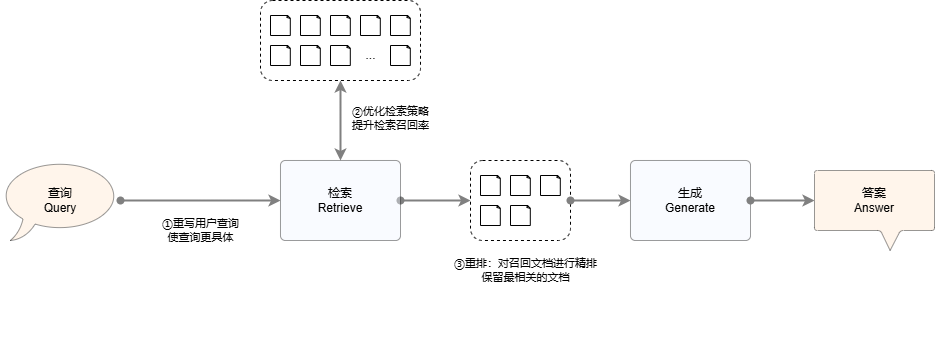
图2：提升 RAG 系统召回率的常用优化方法

### **RAG 的效果，重点在 R**

**示例案例：某企业内部知识问答系统优化效果**

> **​背景：​**某企业部署了基于RAG的内部知识问答系统，用于员工快速查询政策与流程。但初期效果不佳，用户反馈准确率低。

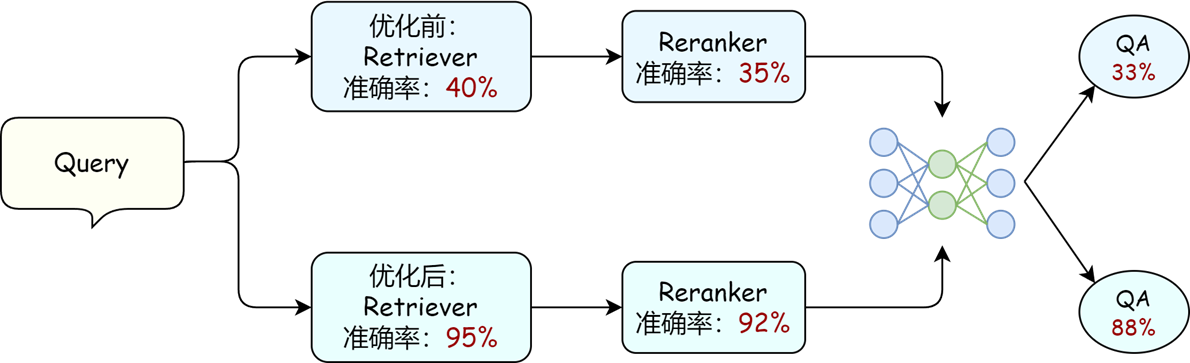

通过引入多路召回、优化重排序策略与微调生成模型，RAG 系统各阶段准确率显著提升，特别是召回准确率从 40% 提升至 95%，带动后续重排准确率提升至 92%，问答准确率提升至 88%。这表明：**召回阶段是提升整个 RAG 系统表现的关键环节**，高质量的召回不仅提高了文档相关性，也为生成组件提供了更准确、丰富的上下文，从而显著提升最终答案的准确率与可靠性。

### 查询重写策略

在实际应用中，用户输入的查询通常是无法预测的，因此从候选集直接命中和query最相关的文档并不容易。查询重写技术可以处理用户查询的歧义，引导其明确用户的真正意图从而检索到准确的文档。此外，查询重写还可以增强检索的多样性，从多个维度搜集信息，下面介绍几种简单的查询重写策略。

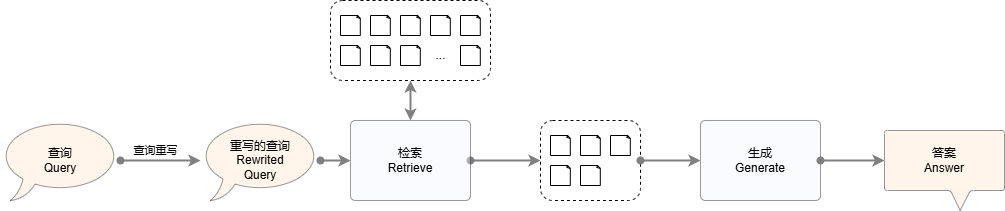
图3：应用查询重写策略的 RAG 系统流程

**1. 扩写查询**

用户输入的查询往往存在歧义或者缺少足够的上下文信息，使得系统难以准确理解其意图并返回最相关的结果。查询扩写（Query Expansion）是一种有效的优化策略，通过对原始查询进行补充、转换或优化，使其更具体、更清晰，从而提高检索的精准度和召回的全面性。

查询扩写的方法多种多样，其中常见的策略包括同义词扩展、上下文补充和问题模板转换。同义词扩展可以增加查询的表达丰富性，提高检索结果的多样性；上下文补充能够利用历史对话信息或用户的先前查询，补充关键信息，减少歧义；而问题模板转换则可以将查询结构化，使其更符合检索系统的最佳匹配模式，从而提高搜索效果。下面将详细介绍这些方法及其应用场景。

（1）同义词扩展：通过引入同义词或相关词汇可以扩展查询的范围，从而提高结果的多样性和全面性，例如将查询“健康饮食”扩写为“饮食健康、健康饮食建议、如何保持健康饮食”等多个形式提供多种角度。

（2）上下文补充：通过分析对话历史或先前的查询，修改当前查询使其更明确。例如在天气相关的话题中，如果用户已经问过了某地当天的天气，再提问“未来14天的天气如何？”时应将历史记录中的地区扩展至最新查询。

（3）问题模版转换：通过将查询转换为特定的问题模板增强检索效果，例如将查询“xxx是啥？”重写为“xxx的定义是什么？”。

**2. 子问题查询**

子问题查询策略的核心思想是生成并提出与主问题相关的子问题，从而更好地理解和回答主问题。子问题通常更具体，能够帮助系统更深入地理解主问题，通常用于比较抽象的问题。简单的子查询构造流程可以总结为如下流程图：

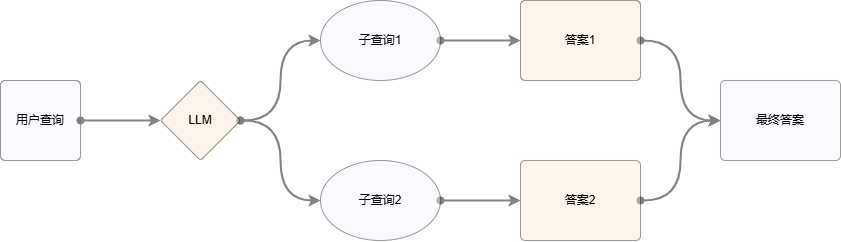
图4：子问题查询策略示意图

（1）通过 LLM 从用户查询中生成多个子问题，例如对原始问题“RAG是什么？”，可以进行如下子查询分解：“RAG的定义是什么？”，“RAG的特点是什么？”，“RAG的原理是什么？”等，子查询构造可以为问题提供多种角度，从而使答案更加具体更加全面；

（2）每个子问题都经过RAG获取相关答案；

（3）将所有问题合并以获得最终答案。

子问题方法虽然可以提升检索组件的召回多样性，但是带来的时间损耗也是较大的，此时可能需要同步进行工程优化保证系统响应时长不会太久。也可以考虑只进行子问题的检索而不为每个子问题进行答案生成，将所有相关文档与主问题传入生成组件。

**3. 多步骤查询**

多步骤查询的核心思想是利用大模型将复杂查询拆解为多个子问题，首先生成子问题1并获取答案，再将答案与上下文一同输入大模型生成子问题2等等，层层推进，直至得到最终答案，适用于需要多轮推理或信息串联的场景。

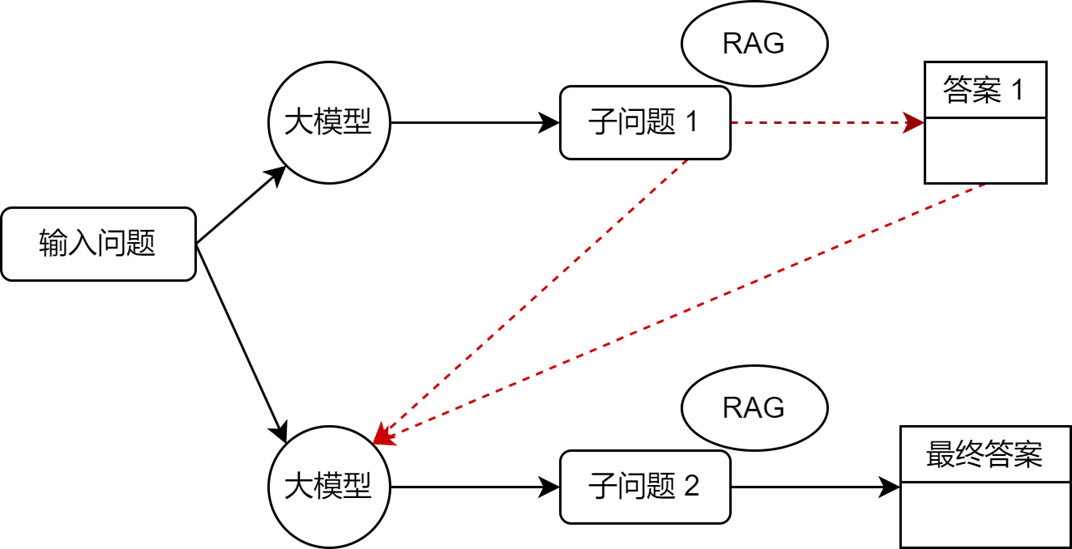

例如，当我们提出问题：“世界上最高的山峰有多高？”系统会首先将其拆解为子问题一：“世界上最高的山峰是什么？” 并得到答案：“珠穆朗玛峰”。接着，它会将子问题一及其答案作为上下文，生成子问题二：“珠穆朗玛峰有多高？”最终，通过回答子问题二，我们便得到了原始问题的准确答案。简单的多步骤查询构造流程如上流程图。

除了上述三种简单的查询重写方法之外，目前常用的还有HyDE，回溯提示等多种方式以生成更丰富、更具体的查询，感兴趣的读者可以查阅相关论文进行学习。查询重写方法能够根据用户的具体需求和情境提供动态调整，有助于实现更准确和全面的文档召回。

### 优化检索策略

检索是指从用户特定的信息需求出发，对特定的信息集合采用一定的方法，根据一定的线索与规则从中找出相关信息的一种技术。图5展示了一次简单的检索流程，首先将给定的查询与文档库中的五个文档进行对比，发现 id 为 2 和 3 的文档与查询相关度更高，因此返回了这两篇文档。

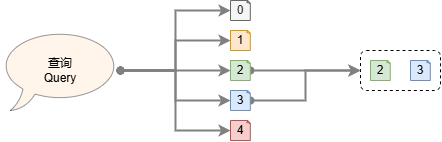

图5：一次简单的检索流程，对每个文档进行相关度计算后返回最相关的文档

检索流程最重要也是最有挑战性的一个问题就是如何衡量查询与文档的相关度，找到与查询最接近的文档。根据已有的自然语言处理技术以及信息检索相关技术，我们可以从以下几个维度进行优化：

（1）被检索对象（节点组，Node Gorup）：将单个文档拆分为多个强针对性子单元。长文档通常包含多个主题，直接检索时可能因主题分散而导致相关内容未被成功召回。但通过合理的分块或摘要提取等策略，可以将长文本拆解为更具针对性的片段，使得检索系统能够更精准地匹配查询内容，从而提高相关信息的召回率和检索质量。在RAG中，这种策略被称为文档解析，通过同一种规则解析出来的所有文档片段被称为一个节点组，不同的节点组适合不同特点的任务。

（2）被检索对象的表征方式（原文vs向量化）：对文本进行向量化与否，如进行向量化，选择哪种向量化模型。合适的文档表征方式可以为检索的准确性提供一定的帮助，向量化的文档表征方式可以保留语义信息，召回语义相似度高的文档，而没有进行向量化的文档可以快速找到相关关键词出现的段落。

（3）检索对象的具体检索方式（相似度，Similarity）：根据检索对象的表征方式选择合适的相似度计算方法。在选择文档表征方式后，需要选择合适的相似度计算方法进行召回，例如如果选用了原文表征，则不适合使用向量相似度作为相似性度量。

综合上述三个维度的考量，可以较大提升检索组件的召回率，为下游提供与查询相似度更高的上下文。下面将详细介绍上述三种策略的细节及合适的场景。

#### 节点组

本节探讨 RAG 系统中常见的两种节点组构造方法，分别是基于分档分块的节点构造策略和基于语义提取的节点构造策略。文档分块部分重点分析固定大小分块（Fixed Size Chunking）和递归分块（Recursive Chunking）。其中固定大小分块方法简单直接，但可能破坏文本的语义连贯性；而递归分块法通过引入分隔符来划分文本，能更好地保留语义完整性。随后，我们将介绍如何利用摘要、关键词提取、问答对提取等方法生成语义信息更为突出的节点优化检索效果。例如，摘要可以帮助系统快速获取关键信息，关键词提取可以加速检索，问答对则能够直接提供标准化的高效响应。通过本节的学习，您将了解到不同的节点构造策略如何影响 RAG 系统的召回效果，并学会如何针对具体任务选择合适的节点组，提高信息检索的准确性和效率。

节点组是检索组件执行检索操作的对象，一次检索只针对一个节点组进行。图5 展示了如何从原文构造节点组：针对文档集中的所有文档，通过应用不同的解析规则得到几个不同的节点组。不同节点组中的内容互不相同，例如通过不同的长度约束对文档分块得到不同粒度的文档块节点组或通过摘要提取等语义处理手段得到主题相同但文本有所差异的节点组。

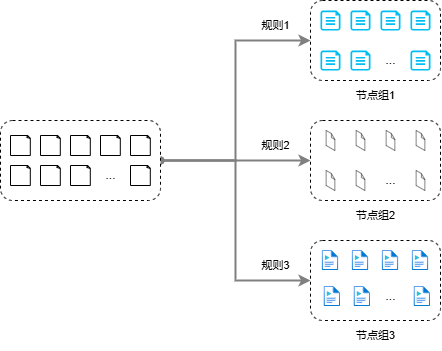

图6：由源文档根据不同规则构建多个节点组

​**1. 基于文档分块的节点组构造方法：**

一段长文本通常包含多个主题，且当文档过长时系统处理的效率也会降低。文档分块（Chunking）是一种将文档切分为多个子段落的方法，切分后的段落聚焦不同的主题，内容更有针对性，更易于在特定查询中返回准确的结果。文档分块策略的选择会和任务有一定的相关性，根据不同的任务合理选择分块策略对提升RAG召回效果有一定的帮助。最常用的两种文档分块策略是固定大小分块和递归分块，在多数任务中都有不俗的表现。

（1）固定大小分块（Fixed Size Chunking）

固定大小分块是最直接，也是最常见的分块方法，它将文本直接拆分成预定大小的块，例如我们指定每20个“字”一组划分成一个块，但是“字”这个概念在大模型处理任务中并不准确，我们通常以“token”作为单位，一个token可以是一个单词、一个标点符号、一个数字、一个符号等。固定大小分块的方式虽然成本低廉，但缺乏上下文感知能力，往往会忽略文档内容或形式。我们可以使用重叠块来改进这一点，让相邻的块共享一些内容。图7（1） 左侧例子是一个固定大小分块的示例（其中每种颜色代表一个块，绿色部分为相邻块间的重叠部分，这个例子选择的固定大小是25，重叠数是5），观察分块结果，可见“一株是枣树”这句话被强行分割为两个部分，我们无法通过第一个文档块获得两株树的详细信息，也无法从第二个文档块获得枣树是在后园里，这破坏了文档的连贯性。

（2）递归分块（Recursive Chunking）

与固定大小分块不同，递归分块通过逐步细分文本来提高处理效率和上下文理解。具体来说，递归分块首先使用主分隔符（如段落）拆分文本，然后如果分块仍然太大，则应用次要分隔符（如句子）。这样在每次分块过程中，模型会依赖信息检索来获取相关上下文，从而增强生成的准确性和质量。这种递归的分块方法能够在不丧失关键信息的前提下，处理更长的文本。与固定大小分块相比，该方法可以保留一定程度上的语义连贯性，保证每个块的语义内容是完整的。例如下图7（2） 右侧例子展示了以换行符为分隔符的例子，与固定大小分块相比，该方法可以保留一定程度上的语义连贯性，保证每个块的语义内容是完整的。

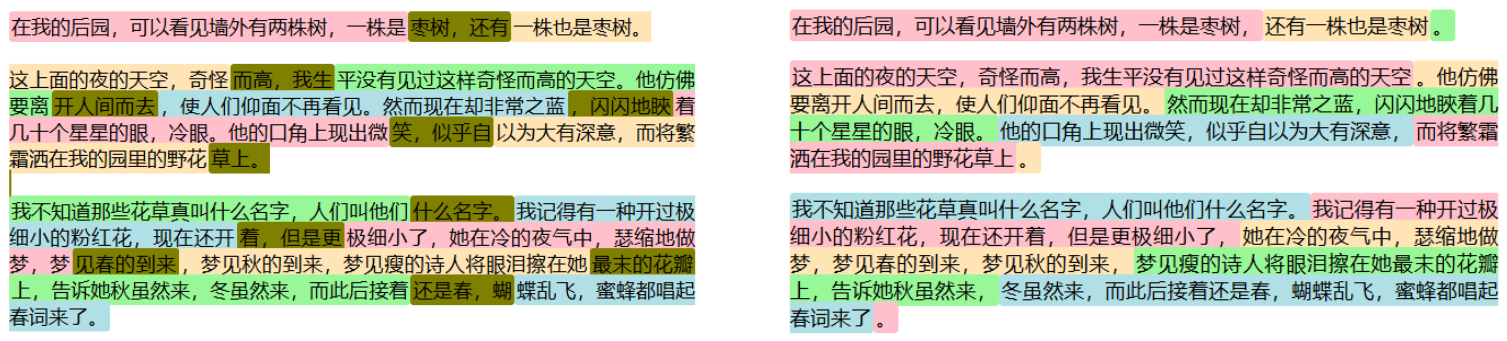

图7（1）：文档分块效果示例，图中每个颜色的文段会被当做一个节点，左侧为固定大小分块法，右侧为递归分块法

（3）语义分块（Semantic chunking）

语义分块是一种基于文本语义信息进行的分块方法，它不依赖于简单的字符或词的长度，而是根据文本中的语义单元进行分割。具体来说，它首先将文本通过向量化，然后计算嵌入之间的余弦距离，将特征距离近的嵌入组合在一起构成一个块。通过这种方式，文本被拆分成具有语义完整性和连贯性的块，每个块内的内容通常围绕一个特定的主题或意思展开。例如图7（2）中左侧例子对文档进行了语义分块，可见将标题和对应的内容分到了一个块中，相比于直接基于换行符（“\\n”）进行分块，保证了一定的语义连续性。

（4）基于文档的分块（Document-based chunking）

基于文档的分块在大规模文本处理和信息检索系统中较为常见。与传统的基于字符或词的分块方法不同，该种方法根据文档中的自然划分（例如标题或章节）创建分块，每个文档作为一个独立的处理单元，这样的分块方式有助于保持文本的整体语境和信息结构。这种方法对于 HTML、Markdown 或代码文件等结构化数据特别有效，但当数据缺乏明确的结构元素时用处不大。例如图7（2）右侧示例，相比于图7（1）左侧示例，对标题和内容进行了较好的区分，保持了原文本的结构性没有被破坏。

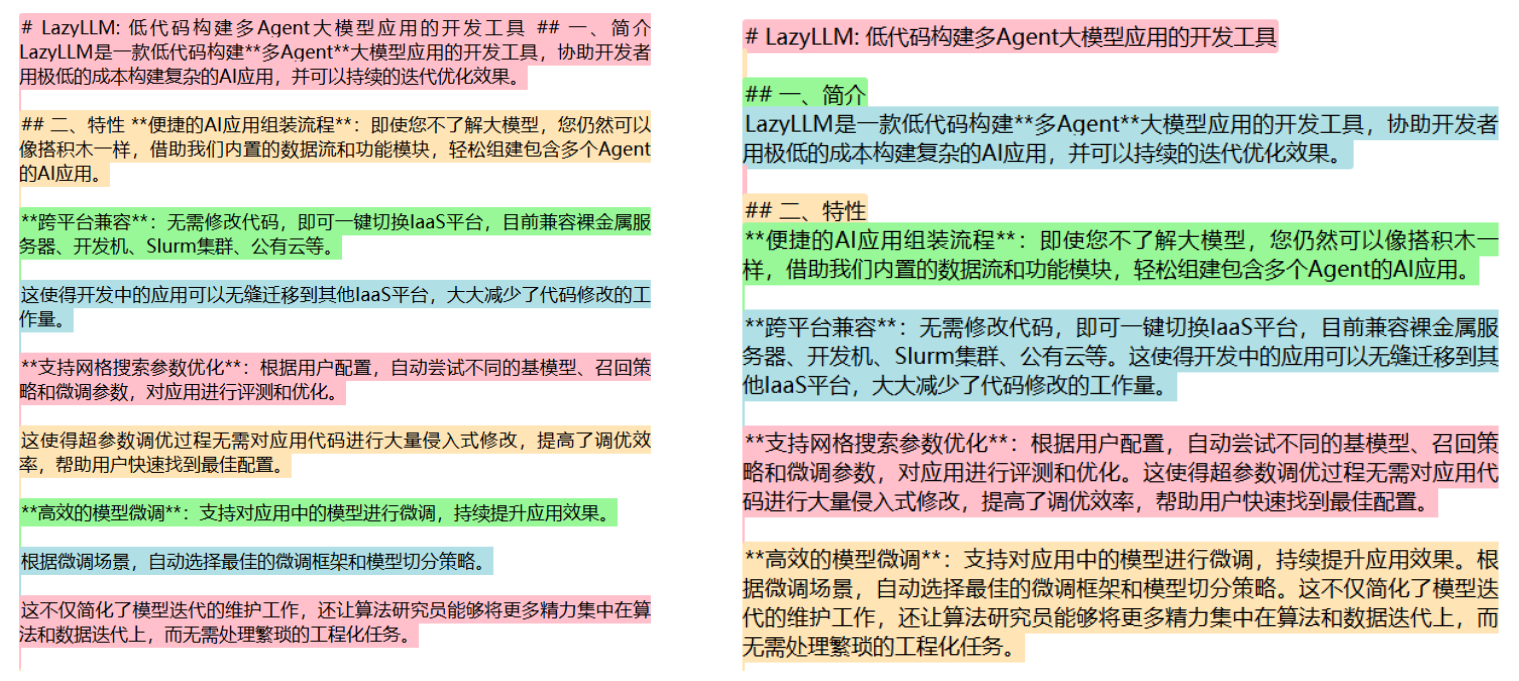

图7（2）：文档分块效果示例，图中每个颜色的文段会被当做一个节点，左侧为语义分块法，右侧为基于文档特点的分块法

**2. 基于语义提取的节点组构造方法：**

当我们采用符号级的分块方式对文档进行处理时，面对复杂的结构化数据、长文本或跨多个文档的信息整合问题往往会遇到诸如上下文缺失、语法和语义理解不足等问题。这是因为传统的符号级分块方法主要侧重于文本的字面层次，无法有效捕捉更深层次的语义和上下文联系。为了弥补这一缺陷，我们可以引入摘要或关键词等包含一定语义信息的文本进行检索，目前这些节点组的构建无需人为一条一条提取，可以直接通过调用大模型实现。例如摘要可以快速提取关键信息，减少无关内容干扰；关键词则可以加速检索过程，缩短查询响应时间；问答对可以通过标准化的问题和答案，提供了即时、精准的响应，提升用户体验。

下面通过一个打印机售后服务的场景，简单解释摘要、关键词、问答对节点组的优势：

（1）关键词节点组：

用户询问：“如何清理打印机的墨盒？”

如果文档没有有效的标签和关键字，系统可能需要逐段查找与“墨盒清理”相关的信息，导致效率低下。如果我们通过关键词提取技术从文档中提取出“墨盒清理”相关的关键字，如“墨盒”、“清洁”、“清洗步骤”等，那么通过这些关键字，可以快速定位对应段落。从而将这些相关段落和用户提问送给大模型进行回答，有效提升检索效率。

（2）摘要节点组：

用户询问：“如何连接我的打印机到Wi-Fi？”

对于这个问题，如果检索关键字Wi-Fi，除了连接Wi-Fi，还会有其他操作相关的文档，此时关键字检索就会失去一定的准确性。通过生成整篇文档的摘要，我们可以从文档中提取出核心信息，以长度适中适合阅读的形式进行存储。例如，打印机连接设置相关内容部分生成摘要后对应文档部分的摘要信息中必然包含打印机的Wi-Fi连接信息。在获取摘要对应的原文后，将其与用户问题一并传入大模型，实现基于上下文的回答。

（3）预置QA对节点组：

用户询问：“我的打印机提示纸张卡住，我该怎么做？”

直接从文档中查找可能会发现“纸张卡住”的处理步骤分散在多个段落内。此时，通过抽取问答对的方式，可以预先将“纸张卡住”相关的所有信息抽取并存储为一个标准化的问答对，例如：问题：我的打印机提示纸张卡住，我该怎么做？**​ ​**答案：1. 关闭打印机并拔掉电源。2. 打开纸盘，检查是否有卡住的纸张。3. 小心地取出卡住的纸张并重新启动打印机。接着将召回的问题（召回时只根据问题进行召回）和答案以及用户提问一起传给大模型，完成用户问答。

#### 原文 vs 向量化

原文与向量化（也称为嵌入，embedding）是自然语言处理中常用的两种文本表征方式，其中原文即文本本身，向量化则是通过嵌入模型将文本映射为高维向量的表示方式。两种表征下的文本对应不同的检索方法，基于原文的检索（Lexical Search）指的是关键词匹配等基于符号的检索方法，也称为原文匹配；基于向量的检索也称为语义检索（Semantic Search），指的是通过统计学习或神经网络将原文映射到高维向量空间，然后在向量空间进行相似度计算的方法。

基于原文的检索的优势是（1）可以精准匹配关键词，适用于结构化文档、法律法规、技术文档等关键词较为固定的场景；（2）结果可解释性强，检索出的文本往往与查询词高度一致，方便用户理解；（3）计算成本低等优势，通常是基于倒排索引实现，查询速度快，存储开销相对较小。但其劣势是缺乏语义理解，对长文本召回率低，原文检索无法识别同义词、近义词等变体，导致查询稍有不同就可能无法检索到相关信息，且如果查询词不在文本中出现，原文检索无法召回相关段落。

语义检索的优势则是（1）具备语义理解能力：可以识别同义词、上下文相关概念，即使查询词没有直接出现在文档中，也能匹配相关内容；（2）适用于复杂查询：能理解长句、问题式查询（如“如何清理打印机墨盒”），适用于对话系统、智能问答等应用。（3）提升召回率：能够找到语义上相似但措辞不同的文本，使检索更加全面。但其劣势是计算成本较高，需要预训练向量模型，并在查询时进行向量计算，资源消耗较大。且检索质量依赖训练数据质量，在某些专业领域（如医学、法律）可能需要额外微调以提升准确性。

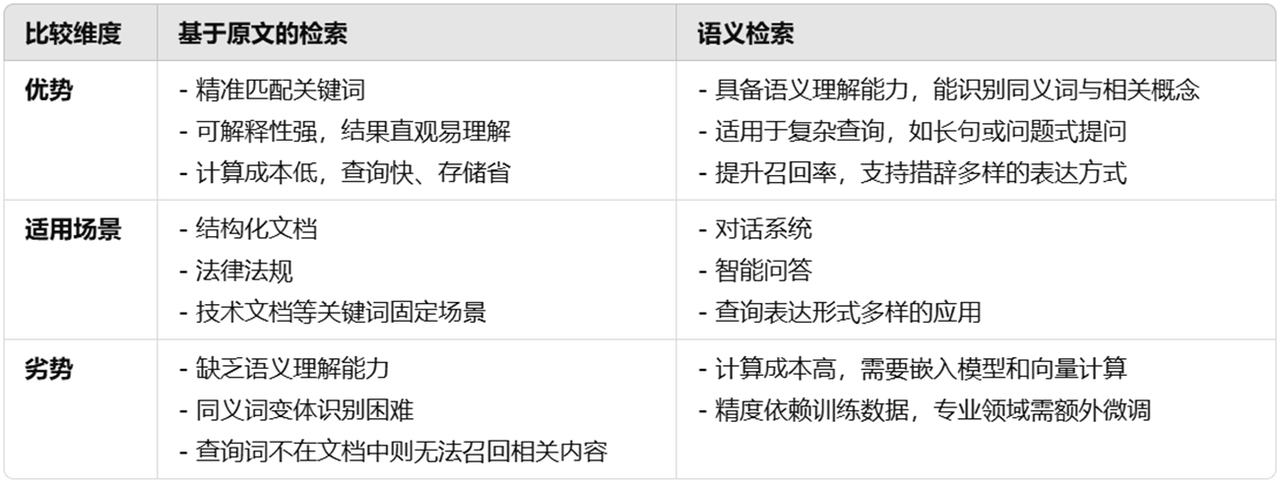

在实际应用中，我们可以根据需求结合基于原文的检索方法和基于向量的检索，优化系统最终效果。在实现方式上，基于原文的检索通常比较简单，只需对文本进行分块存储，检索时进行原文匹配即可。而语义检索则需要在系统开始工作前先对文本进行向量化，完成这一步之后才能开始接收用户查询进行后续检索。下文对文本嵌入技术进行简单介绍。

**1. 文本嵌入是一种什么样的技术**

文本嵌入技术最早是对单词进行向量化，也就是把一个单词映射成一个数学向量，便于计算机进行相关计算。图8 给出了一个简单的例子：针对“我爱我家”这四个字进行向量编码。首先建立一个词表，在这个例子中只有三个字，因此词表大小为3，依次为“我”，“爱”，“家”；然后按照顺序将每个字出现的位置标记为1，其余位置为0，在这个词表中“我”字对应的是[1,0,0]，“爱”字对应的是[0,1,0]，“家”对应[0,0,1]；因此我爱我家这个短语对应的向量化表示如图8右侧矩阵所示。这就是独热编码（one hot embedding），独热编码是一种经典的单词向量化算法，可以对词表中的所有词进行区别化表示，但随着词表的扩大向量维度也会无限扩大，在存储和计算方面都会遇到瓶颈。

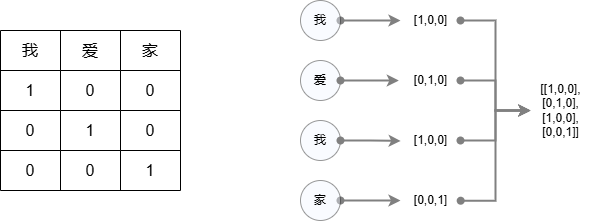

图8：独热编码示例

单词向量虽然可以达到将文本映射为向量的目的，但如果是一本书的数据量，那最终的向量维度又会是多少？因此我们需要更高效的向量化方法，即句子（或段落）的向量化技术。早期实现句子向量化的方法是对词向量取均值（例如上述例子中“我爱我家”的句子向量就是 [1, 0.5, 0.5]）。但这种方法通常效果较差，因为它忽略了上下文以及词的重要性等因素。

2014年，谷歌提出了 transformer 结构，基于 transformer 结构的网络具有强大的表示能力和适应长序列数据等优点，直到现在 transformer 在机器学习，自然语言处理等领域依然是主流的基础网络结构。目前通常使用的都是基于 transformer 网络的可以保留上下文语义的 Embedding 模型，这些模型将分块后的文档映射成一个在一定程度上保留文本的上下文信息的固定维度的向量。向量之间的距离或角度可以反映文本之间的语义相似度，即使两个句子使用不同的词汇，但如果它们表达相似的意思，它们在嵌入空间中的距离会很近，这是原文匹配难以做到的。目前常用的文本 Embedding 模型有 bge 系列和 jina 系列等，用户可以根据需求在 huggingface 等平台找到对应的模型权重，或者调用主流大模型厂商提供的在线模型。图9 展示了通过神经网络对“我爱我家”四个字进行嵌入的例子，与图8 中的独热编码相比，其结果维度更高，数值更复杂，但在面相大规模数据的实际应用中的效果往往更好。

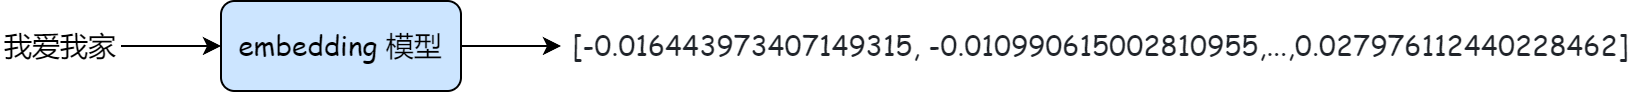

图9：基于神经网络计算文本嵌入示例

**2. 如何通过Embedding进行检索**

不难想象利用原文进行检索的算法就是根据用户查询和原文的文档片段进行关键字匹配等，用 Embedding 该如何进行向量检索呢，我们先看下面的图：

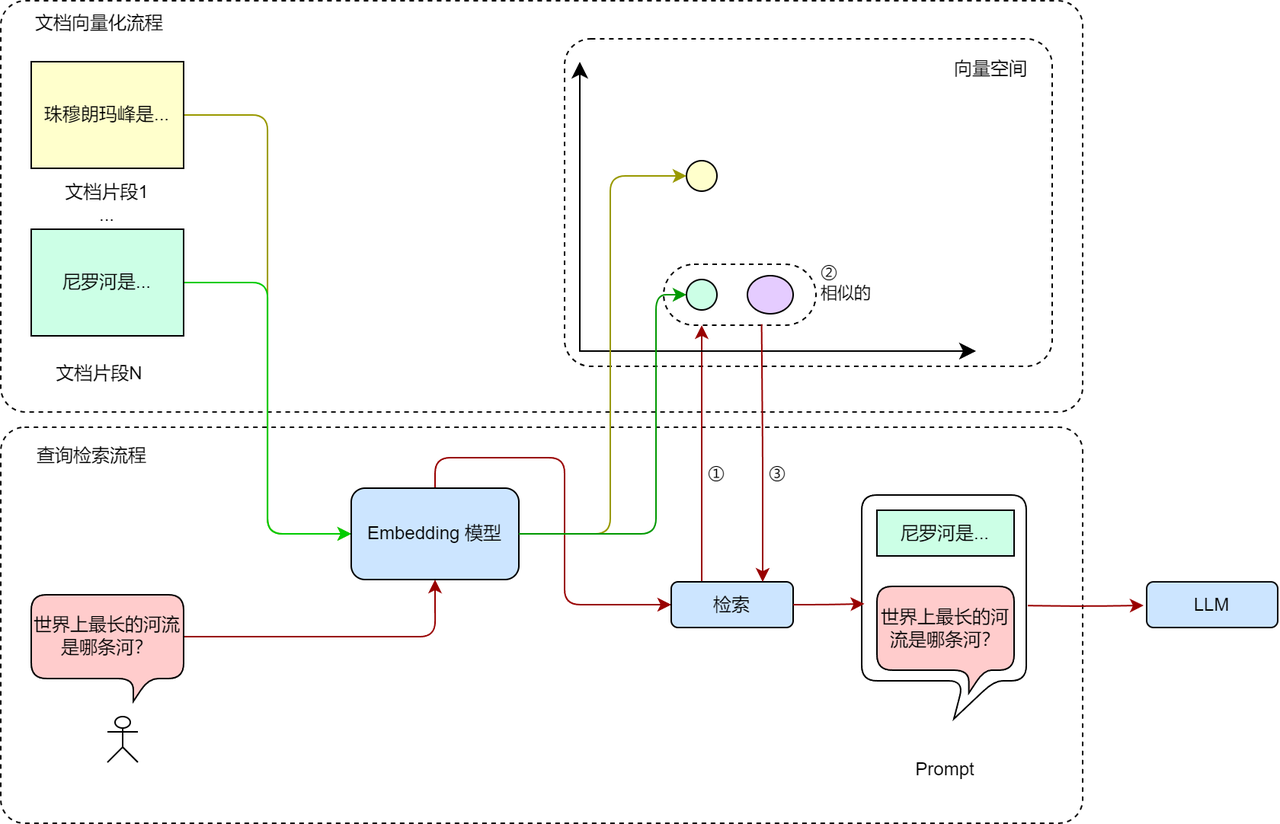

图10：利用向量化技术实现的 RAG 系统工作流程示例

图10 展示了基于语义检索的 RAG 检索组件工作流程，主要有文本向量化流程和查询检索流程两个部分构成，其中文档向量化部分对切片后的文档进行向量化，实现从句子到向量的映射工作，这一步通常是离线执行，与用户查询无关；查询检索流部分则是在线流程，这一步中的每一个中间结果都与用户查询相关，具体来说，用户查询经过嵌入模型后，与文档库中的所有向量进行相似度计算，再返回与查询最相关的几个文档片段和用户查询一起输入给大模型。图中展示的是用户查询世界上最长的河流时 RAG 系统的响应示例，假设文本片段1是珠穆朗玛的相关资料，对应的向量是右侧坐标系中黄色的点，而文档片段 N 是尼罗河的相关资料，对应右侧坐标系中绿色的点。当用户输入查询“世界上最长的河流是哪条河？”时，这个查询首先经过与文档嵌入相同的Embedding模型将其映射到文档库所在的向量空间（即图中的 ①）；然后检索器在向量空间寻找与其距离相近的文档向量（即图中的 ②），在这个例子中是代表尼罗河相关资料的绿色点是与用户查询最相关的向量；然后检索器返回文档向量对应的文档原文，即包含尼罗河相关资料的文档片段 N（即图中的 ③）；最后我们把文档片段（尼罗河的相关资料）和用户查询（世界上最长的河流是哪条河？）一同输入给大模型，完成一轮基于嵌入向量的检索和问答。

**3. 大小块策略**

在 RAG 系统中，“小块召回、大块生成” 是一种常见且高效的策略，其核心思想是：

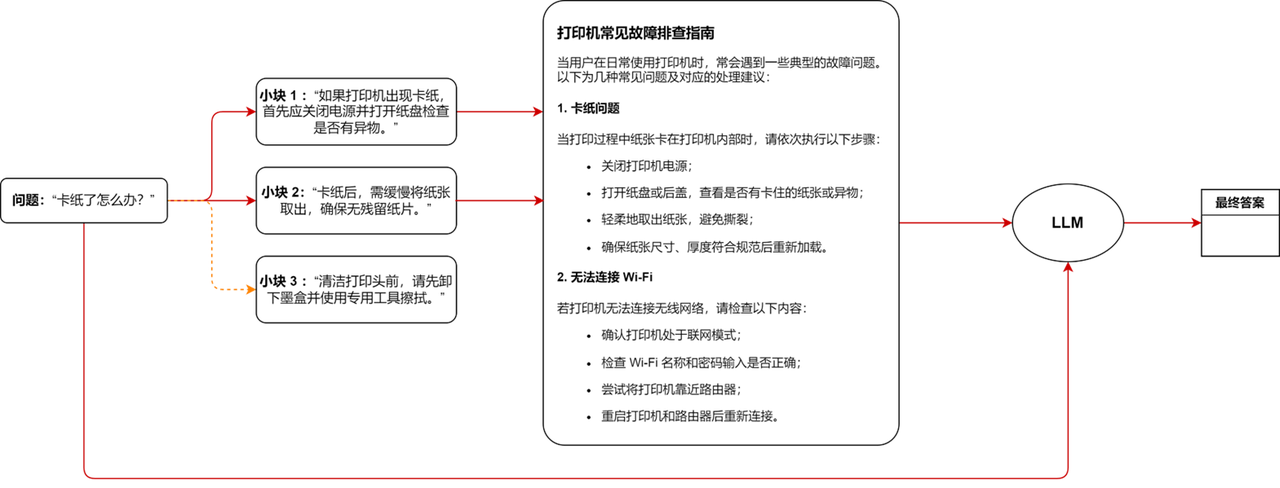

* **​小块召回：​**小块用于高精度召回文档先按较小粒度进行切分（如按段落、句子），每个小块携带更精细的语义信息，便于精准计算与用户查询的相似度。检索阶段只对小块向量进行相似度比对，从而更容易找到与用户查询语义接近的内容。
* **​大块召回：​**大块用于上下文生成一旦某个小块被成功召回，系统会找到该小块所属的大块（如一整节内容或完整子话题），将其作为上下文提供给大模型，用于生成更完整、更连贯的回答。这样做的好处是：避免小块信息太碎，大模型理解困难；同时减少将所有大块入库所带来的计算和存储成本。

**4. 稠密向量与稀疏向量**

上文提到向量化表征文本段落相比于原文匹配的优势是可以保留文段语义，具体表现是相似的文段相似度更高。通常使用的向量检索有两种，一种是稠密向量检索，另一种是稀疏向量检索，下面简单介绍两种方法并分析各自的优劣，您可以根据自己的需求选择合适的检索方式。

（1）稠密向量（Dense Vecotr）：

稠密向量的特点是维度远小于词汇表大小，例如 bge-embedding 的输入可以达到 8196 个token，但输出是固定的 1024 维。稠密向量中大多数元素的值都不为零，一般通过 Word2Vec、BERT、bge-m3、jina-embedding **​ ​**等模型计算得到。获取稠密向量的途径有两种，一种是直接对词向量进行均值池化（多用于词袋模型），另一种则是通过 BERT 等模型计算得到 [CLS] （如图11）对应的向量将其作为当前句子的嵌入向量。由上述计算方式可知，句子（或段落）的稠密向量主要是对当前文段语义的平均，可以识别同义词、上下文相关概念，即使查询词没有直接出现在文档中也能匹配相关内容。但其劣势是对文段的细节捕捉能力不够强和计算成本较高。例如对“人工智能学科成立于1956年。”这一句 query，使用 bge-m3 生成的向量嵌入为 1024 维向量：

```bash
[-0.02427494, -0.02393905,  0.02964895, ..., 0.04020474, -0.01293714]
```

上述并向量没有直接可读的意义，可解释性较差，稠密向量化模型训练复杂，通常需要依赖大量数据。基于稠密向量的文档表示通常在经过向量化模型后可能会丢失文段中的具体的数值、特殊术语、实体名称或句法结构等。而实际应用中，例如在法律或医学等专业领域，某些特定术语和表达方式对于正确理解文本至关重要，而稠密向量可能无法完全保留这些关键信息，导致语义检索难以精准匹配。

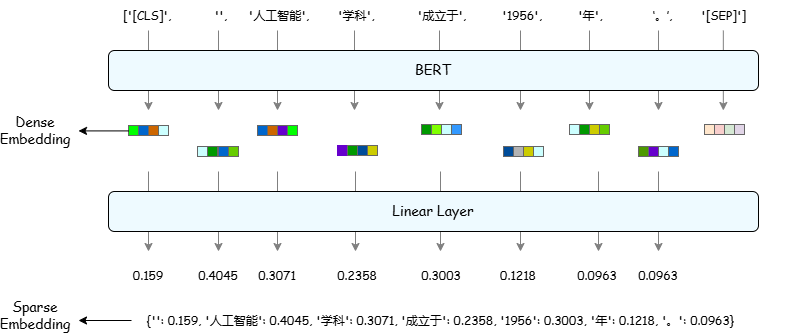

图11：利用神经网络生成稠密向量与稀疏向量对比

（2）稀疏向量（Sparse Vector）：

稀疏向量的特点是维度高，通常等于词表（Vocabulary）的大小，例如 bge-m3 的词表大小是250002，但向量中大多数元素为 0，非零值仅出现在文段中出现的词上。稀疏向量的获取方式也有两种，一种是在构建一个固定大小的词表（如 10 万个词）后对每个文档，在对应词索引位置上填充词频（TF）或 TF-IDF 权重，未出现的词位置填 0 即得到了稀疏表示。另一种是基于深度学习的方法，目前常用的有 SPLADE、bge-m3 等，这类方法结合了 BERT 语义建模和稀疏向量的可解释性，将查询和文档表示成稀疏的词向量，从而兼顾传统算法的词匹配能力和深度学习模型的语义理解能力。相比于稠密向量关注文段的平均含义，稀疏向量表示在词表上计算每个词的权重，能够保留更多的细节。稀疏向量的维度非常高，且多数元素为 0，因此基于数组数据结构的存储方式性价比极低。稀疏向量通常以（pos, value）的形式存储，其中 pos 表示词表位置，value 表示当前词在这个文段的权重。以 bge-m3 为例，计算稀疏向量，先对句子分词，通过 BERT 得到单词的向量，然后通过一个线性层在词表上计算每个单词的权重，而不是用 [CLS] 位的嵌入概括整个句子。同样对于“人工智能学科成立于1956年。”， bge-m3 的稀疏嵌入输出为：

```bash
{'6': 0.159, '81492': 0.4045, '72584': 0.3071, '104220': 0.2358, '189638': 0.3003,

'470': 0.1218, '30': 0.0963}
```

其中 '6' 表示对应向量第 7 个位置的值为 0.159，也就是说在当前这个文段中，词表中第 7 个词的权重是 0.159。

通过比较 BGE-M3 的稠密表示和稀疏表示可以发现，稠密表示对于任意长度的文段输出均为 1024 维向量，而稀疏表示则与文段长度和出现的词相关。稠密向量的每个维度都包含信息，其数值通常较小且分布均匀，代表文本在高维语义空间中的整体位置。这种表示方式能够捕捉复杂的上下文信息，使其在计算语义相似度时更具鲁棒性。然而由于稠密向量是高维连续值，其可解释性较差，很难直接理解每个维度的具体含义。相较之下，稀疏向量的非零维度较少，通常与具体的词汇项直接对应，并带有相应的权重，权重大小反映了该词在文段中的重要性。这种表示方式使得稀疏向量更易于索引，能够与传统的倒排索引结合，提高检索效率。

在实际应用中，稠密向量适用于语义匹配、跨语言检索，因为它能在高维空间中捕捉上下文信息和隐含关系，而稀疏向量适用于高效的关键词搜索和可解释性需求较强的任务。两者各有优劣，结合使用可以同时利用稠密表示的语义能力和稀疏表示的高效索引能力，实现更精准的搜索和匹配。

#### 相似度计算方法

上文提到向量化之后的文本嵌入会保留原文的语义，即语义相似的文档嵌入之间的相似度会更高，为了准确地找出与用户查询相似的文档片段，我们需要选择合适的距离度量函数进行相似度计算。朴素的相似度计算流程是对用户查询进行向量化后，将该向量与文档库内的所有向量逐个计算相似度进行排序，选择指定的 top-k 个作为结果，或者进一步地选择相似度满足某个阈值的点作为最终结果。假设以二维向量作为嵌入维度，图12 中所有蓝色点表示文档库内的向量，红色点为查询向量，将红色点的向量和其他所有蓝色点进行计算，选择距离最近的k个点作为结果，或者选择满足距离阈值（即红色圆圈）的两个点作为召回结果。

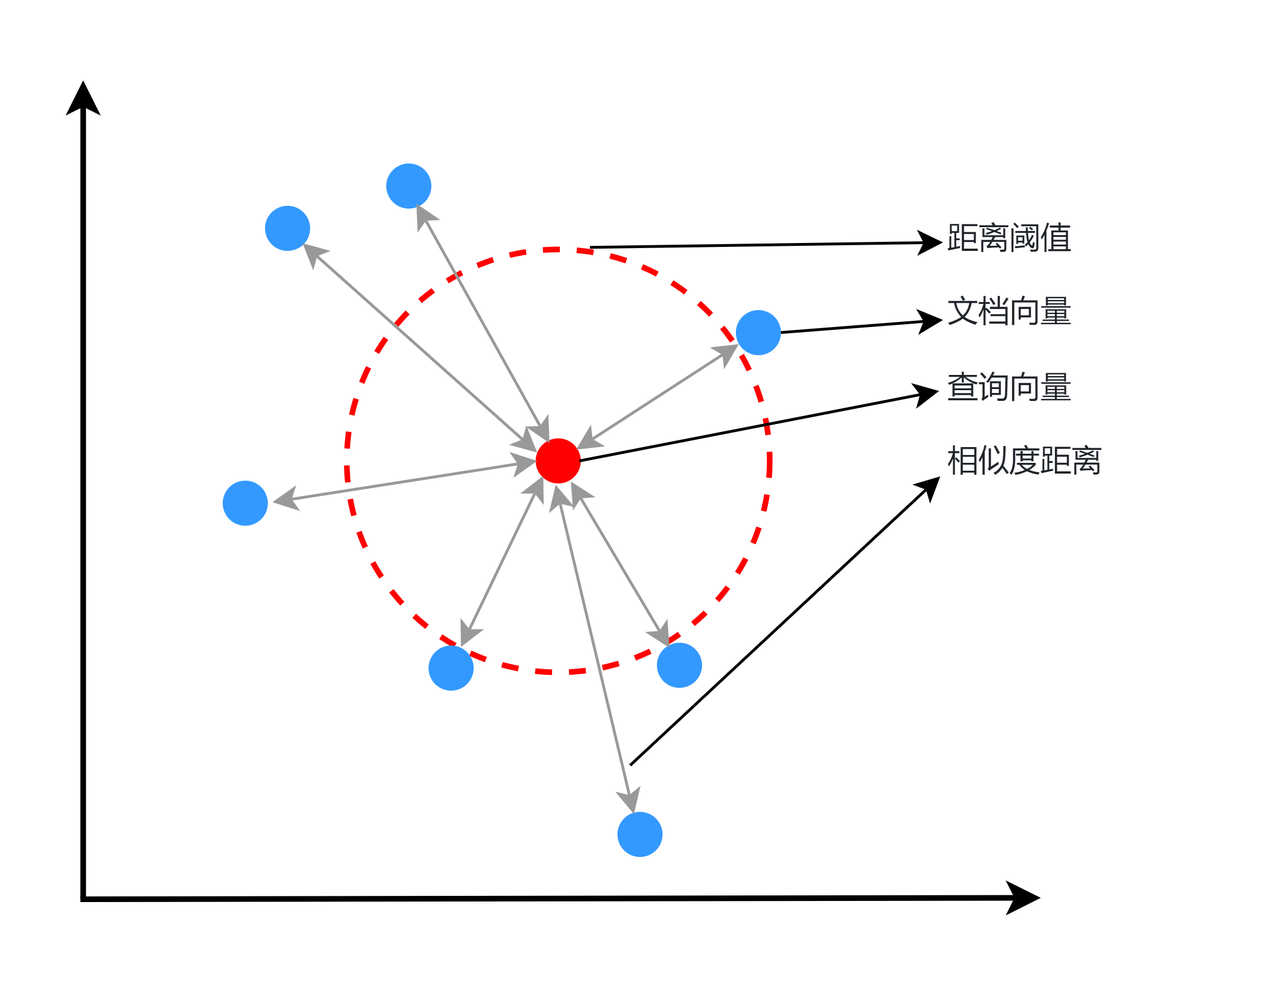
图 12：向量相似度计算

**1. 内积（Inner Product)**

向量是由n个实数组成的一个n行1列（n\*1）或一个1行n列（1\*n）的有序数组。向量的内积,也叫向量的点乘、数量积，对两个向量执行点乘运算，就是对这两个向量对应位一一相乘之后求和的操作，点乘的结果是一个标量。设向量 **a ​**和 **b ​**分别为

$$
\begin{cases}
x = [x_1, x_2, \ldots, x_n] \\
y = [y_1, y_2, \ldots, y_n]
\end{cases}
$$


则 **a ​**和 **b ​**的内积公式为：

$$
x \bullet y = x_1 y_1 + x_2 y_2 + \ldots + x_n y_n
$$


内积反映了两个向量在同一方向上的“投影”程度。在几何意义上，内积越大，表示这两个向量在同一方向上越接近，内积为0时两个向量正交，即线性无关。我们通常使用内积作为在稀疏向量的距离度量指标，下面看一个例子，假设有 3 个 TF-IDF 向量：

A=(0, 0.3, 0,  0.7, 0,  0.5) 

B=(0, 0.4, 0,  0.6, 0,  0.2) 

C=(0,  0,   0.8, 0,  0.6, 0 )


以稀疏表示存储：

A = {1: 0.3, 3: 0.7, 5: 0.5}

B = {1: 0.4, 3: 0.6, 5: 0.2}

C = {2: 0.8, 4: 0.6}

计算内积：

IP(A, B) = (0.3×0.4)+(0.7×0.6)+(0.5×0.2)

=0.12+0.42+0.10

=0.64

IP(A, C) = (0.3×0)+(0×0.8)+(0.7×0)+(0×0.6)+(0.5×0)
            
= 0


可得向量A和B的相似度为 0.64, 向量 A 和 C 的相似度为 0.

**2. 余弦相似度（Cosine Similarity）**

余弦相似度是一种标准化的内积度量，它衡量的是两个向量在方向上的相似性，而不考虑它们的长度（即模），如图中的 **x，y ​**与 **x,  z ​**虽然长度不相同，但它们的余弦相似度是相等的。

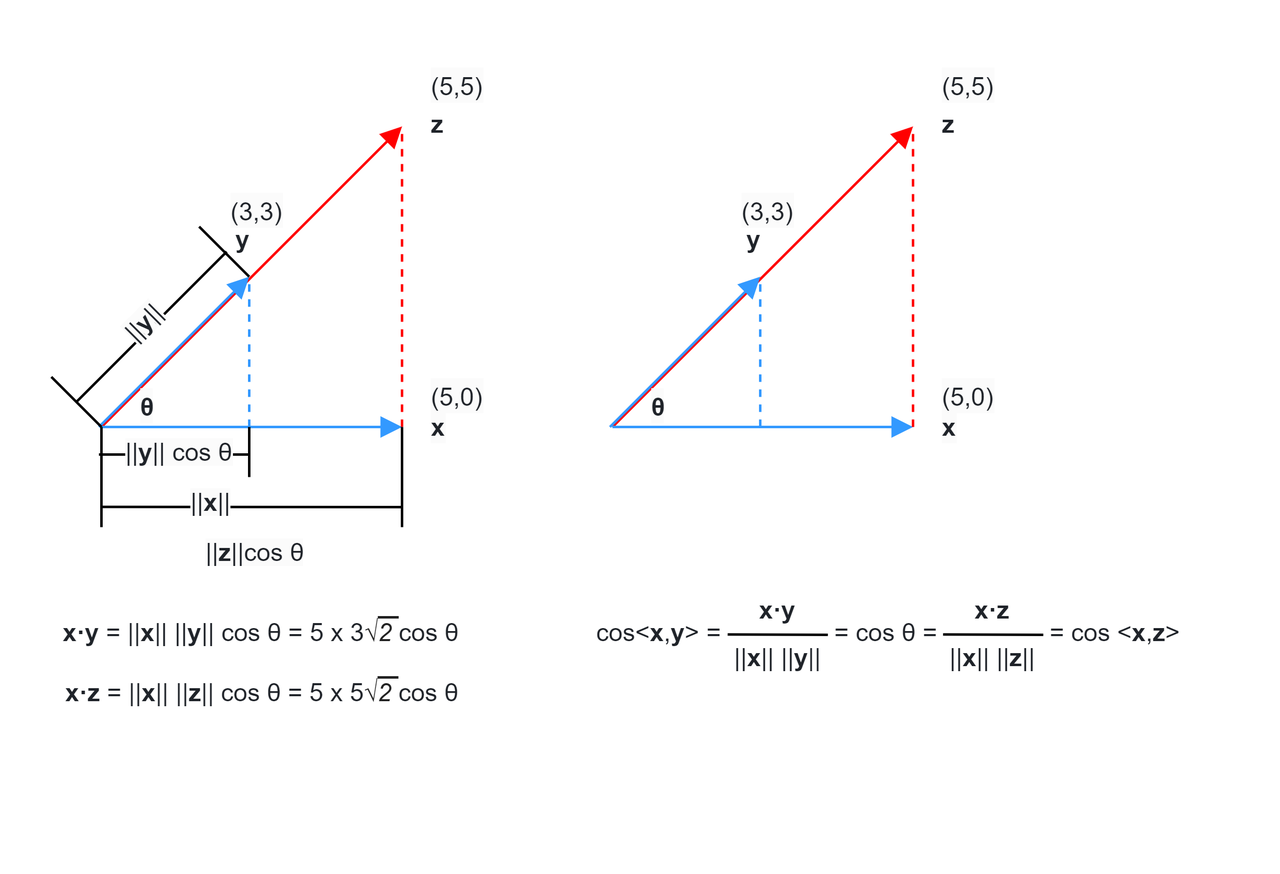

图13：内积与余弦相似度对比，其中左侧为内积，右侧为余弦相似度

余弦相似度的计算方式如下：

$$
\text{Cosine Similarity} = \frac{\vec{x} \cdot \vec{y}}{||\vec{x}|| \times ||\vec{y}||}
$$


其中，∥x∥ 和 ∥y∥ 分别是向量x和y的模（即长度）。余弦相似度的取值范围是[-1,1]，其中 1 表示完全相同的方向（即图中的 ​**y**​，​**z**​），0 表示正交（即没有相似性），-1 表示完全相反的方向。NLP 任务中余弦相似度通常是最佳实践，其中 1 表示完全相同的方向，0 表示正交（即没有相似性），-1 表示完全相反的方向。在稠密向量的距离计算中，我们通常使用余弦相似度为距离度量指标。

**3. bm25**

bm25（best matching 25）是一种基于概率模型的排序方法，它针对文档中关键词的频率进行了优化。BM25的核心思想是，根据词频（Term Frequency, TF）和文档长度对文档的相关性进行建模，同时引入了对文档中常见词的“惩罚”机制，是传统搜索引擎中广泛应用的一种方法。与cosine和IP相似度不同的是，bm25并不是通过embedding进行相似度计算，而是通过以下几个原则来衡量一个文档对于某个查询的相关性：

（1）词频（TF）：文档中某个词出现的次数。直观来讲一个词在文档中出现得越多，文档与该词的相关性就越高。

（2）逆文档频率（IDF）：衡量某个词在整个文档集合中的稀缺性。出现频率高的词可能对区分文档的重要性较低，因此要降低它们的权重；而稀有的词则更能区分文档的重要性。其定义为：

$$
\text{IDF}(q_i) = \log\left( \frac{N - df(q_i) + 0.5}{df(q_i) + 0.5} + 1.0 \right)
$$


其中N是文档总数，df(qi) 是包含查询词 qi 的文档数。

（3）文档长度的归一化：短文档与长文档的词频分布不同，BM25通过对文档长度进行归一化，减少文档长度对相关性的影响。

已知上述基本思想，记文档为D，查询为Q，f(qi, D)为查询词qi在文档D中的词频，bm25的计算公式定义如下：

$$
\text{Score}(D, Q) = \sum_{i=1}^n \text{IDF}(q_i) \cdot \frac{f(q_i, D) \cdot (k_1 + 1)}{f(q_i, D) + k_1 \cdot \left(1 - b + b \cdot \frac{|D|}{\text{avgdl}} \right)}
$$


其中|D|为文档D的长度，avgdl是所有文档的平均长度，k1和b是调节参数，通常情况下k1在[1.2,2.0]之间，b设置为0.75.其中k1控制词频的影响。较大的 k1 值增加词频对相关性计算的影响，而较小的值则会抑制高频词的影响，防止过度依赖某些常见词。b则控制文档长度的归一化。b 的取值范围是 [0, 1]，当 b=1 时，文档长度对评分的影响最大；当 b=0 时，不考虑长度影响。

以上三种相似度计算方法没有绝对的好与坏，通常情况下用户可以根据自己的需求选择一个或多个方法应用于不同的检索器。通常来说，针对不同的文档表征方式会使用不同的相似度计算方法，下表展示了基于不同向量表征方法对应的稀疏检索和稠密检索常用的组合。

|         | 传统方法（TF-IDF） | 基于BERT的方法（BGE-M3） |
| ---------- | -------------------- | -------------------------- |
| 稀疏检索 | bm25               | IP                       |
| 稠密检索 | cosine             | cosine                   |

### 重排序

召回重排策略也被称为两阶段检索，其中第一个阶段是检索（retrieve），第二个阶段是重排序（rerank），广泛应用于搜索引擎、推荐系统、问答系统等任务中。基本思想是：在初步检索得到一组文档后，通过一个额外的模型对检索结果进行再次排序以提高最终的效果。

已知检索阶段已经输出了相似度分数，且输出的是相似度分数更高的结果，为什么还要进行重排序呢？首先检索器是基于嵌入模型输出的向量进行相似度计算，此时由于信息压缩大致的信息丢失会直接影响检索结果的准确率。其次基于词频等简单特征的 BM25 等传统方法在捕捉深层语义和上下文方面的能力有限也会对检索准确度造成影响。而重排序模型往往是一个体量比嵌入模型更大的模型，通过一个完整的Transformer推理步骤，针对查询和文档生成一个相似度分数，相比于计算cosine等相似度具有更高的准确度。

为什么不直接通过排序模型进行检索而要使用嵌入模型和检索器后再使用排序模型呢？这是因为重排序模型需要同时输入查询和文档，意味着每次查询都需要对全量的文档进行分数计算，这会消耗大量资源并导致系统响应速度变得非常慢，不利于用户体验。而检索器从大数据集中检索少量文档的速度远快于利用重排序模型。两阶段检索算法通常会在检索阶段召回较多的文档，在重排序时从中选取得分高的少部分文档作为最终检索结果，形成一个漏斗状的结构，逐步减少召回的文档数目。

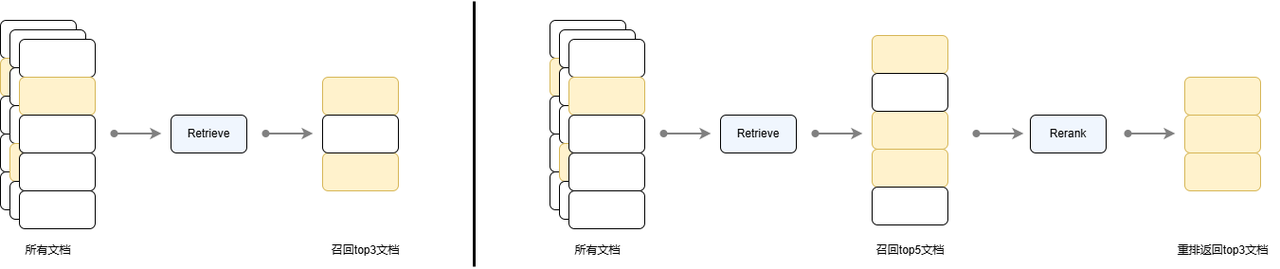

图14：单阶段召回与两阶段召回策略对比，图中高亮部分表示相关文档

由图14可知，在两阶段检索中，Retriever（召回模型）和 Reranker（重排序模型）各司其职，具有不同的作用：其中Retriever 主要负责高效筛选，从海量文档中快速提取与查询相关的候选文档，常见的方法包括语义检索和例如 BM25 的稀疏向量检索。但由于文本嵌入会造成一定的信息丢失，BM25 又无法捕捉语义信息，会在一定程度上影响精准度。为了克服这个问题引入 Reranker 对初步召回的文档进行更精准的筛选，对召回的文档集合进行更细粒度的语义分析，并重新计算相似度得分。常用基于 Transformer 的排序模型（如 `bge-reranker-large`、`bge-reranker-base`）进行重排序步骤，针对查询和文档生成一个相似度分数，能够捕捉更复杂的语义信息，提高最终检索效果，但计算成本较高。在召回重排策略中，Retriever 负责高效召回，Reranker 负责精准排序，两者结合形成“广撒网 + 精筛选”的漏斗式结构，以平衡效率与效果。

## 多路召回RAG

在 RAG 系统中，召回阶段的质量直接决定了最终生成答案的准确性和相关性。传统的单一检索策略可能会遗漏部分关键信息，而多路召回 RAG 通过整合多种检索方式，可以提升检索召回率，从而优化最终的生成效果。引入重排序策略不仅可以对召回的文档进行更精细的筛选和排序，还可以实现多路召回，即基于多个检索器、不同检索策略的联合检索。这种方式可以在不同层次、不同粒度的文档中提取相关信息，从而提高检索覆盖率，提升 RAG 系统的整体性能。

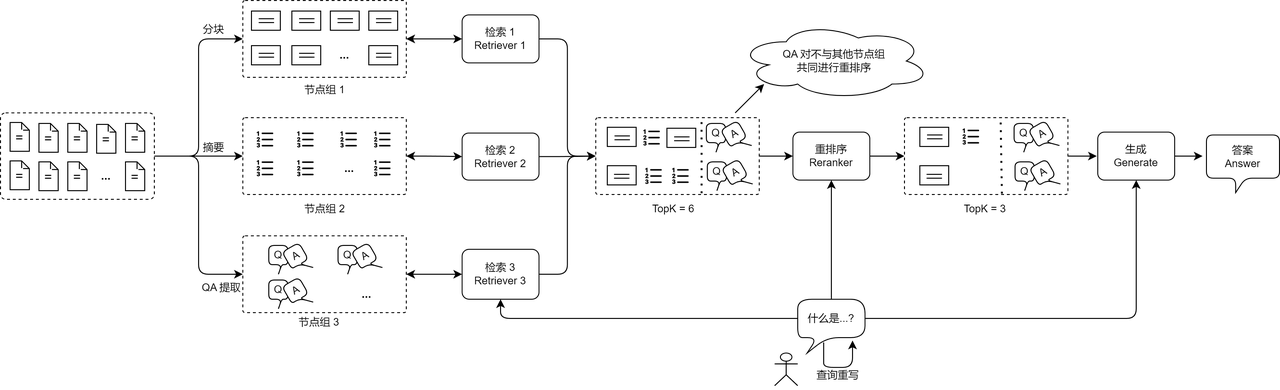

图15：多路召回RAG

在实际应用中，我们可以配置多个不同类型的检索器，每个检索器负责处理不同的数据来源或不同粒度的信息，再对所有检索召回的文档进行排序得到最终的上下文。例如，我们可以通过查询拆分将原始查询划分为多个子查询，分别针对不同的数据集进行搜索，然后将所有的检索结果进行整合、排序，以获得最终的上下文信息。多路召回可以从以下几个关键步骤进行优化：

（1）重写用户查询：针对用户查询，进行同义词替换、历史内容补充、或生成多个子查询，使检索器可以针对不同维度的内容进行检索。以子查询为例，对于复杂的查询，直接检索可能无法涵盖所有相关信息，因此将查询拆分为多个子查询时使不同的检索器针对不同维度进行搜索时可以有效提升上下文的全面性。例如当用户查询：“2023 年 AI 生成内容的主要挑战是什么？”可能的子查询有“2023 年 AI 生成内容的技术限制有哪些？”、“2023 年 AI 生成内容在法规和伦理方面的挑战？”、“2023 年 AI 生成内容的商业应用困难？”，然后，将每个子查询分别输入到不同的检索器分别召回对应的上下文段。

（2）检索多个节点组：采用多个检索器并行检索不同的数据来源或不同的节点组有助于提升系统召回率。在传统 RAG 结构中，通常采用单一检索器从一个数据源中获取信息，而使用多个检索器查询不同数据来源或不同的知识粒度可以有效召回相关文档。例如图15 中的系统设置了三个检索器分别针对原始文档块、文档摘要、预定义的问答对进行检索。这种方式允许 RAG 查询不同粒度的信息，再多个维度上搜索与用户查询强相关的文档片段。

（3）使用多种检索策略：使用不同的相似度函数或多种向量嵌入方法可以最大化现有检索技术的优势。通常将其分为密集检索和稀疏检索。其中密集向量检索，也就是基于稠密向量嵌入计算语义相似度（通常是利用 bge 等模型生成稠密的向量表示，然后使用cosine度量文段相似度），适用于查找语义相近但措辞不同的内容；而稀疏检索则是基于词匹配（如 BM25，splade等），适用于精确匹配关键词场景。二者混合使用可以得到更优的召回结果，例如，在某个法律领域问答系统中密集检索可以找到文本表达有所不同的案例，而稀疏检索则可以精准匹配某个法条或某个具体案例。

（4）结果融合：由于多个检索器可能会返回不同类型的信息，需要将它们融合成一个新的文档集，以供后续排序和生成。例如再用户查询 “AI 监管的最新进展”的场景下，检索器 1 返回了一篇 AI 伦理的学术论文片段，检索器 2 返回了包含 “AI 法规” 关键字的政府公告，检索器 3 返回了 AI 监管相关的博客摘要，此时，系统将所有文档合并去重，构建一个新的的文档集。

（5）重排序：尽管检索阶段已经计算了相似度分数，但不同策略返回的文档重要性可能不同，需要进一步重新排序。传统检索分数可能存在因词频问题导致不相关的文档得分较高，而密集检索则可能会因为信息压缩导致关键细节丢失而输出的是粗排结果。此时重排序模型的作用就是采用更强大的 Transformer 模型（如 `bge-reranker-large`），对检索到的文档重新计算相似度，提高准确性。例如再上面AI监管进展的例子中，经过重排序后的顺序是：AI 监管政策的最新报告（最相关），AI 伦理讨论的学术文章（相关），一篇关于 AI 技术发展的博客（次相关）。经过重排序后，系统只保留最高分的文档进入下一步。这里值得注意的是 QA 对召回的结果不会和其他节点组共同参与重排序流程。

（6）最终答案生成：重排序后系统会选取前 K 个高分文档，并将其与用户查询一起输入到大模型，生成最终答案。以上文提过的AI监管的例子为例，大模型接受用户Query：“AI 监管的最新进展”，可参考的文档：AI 监管政策的最新报告，AI 伦理讨论的学术文章，一篇关于 AI 技术发展的博客，作为输入，根据这三篇文档总结AI监管的最新进展，进行总结恢复。

相比于传统的单路检索 RAG，多路召回 RAG 由于采用了多种检索策略，系统能够覆盖更广的信息范围，减少关键知识遗漏的可能性。其次通过多粒度检索（细粒度文本、摘要、QA 对等），能够捕捉不同层次的信息，可以提升答案的全面性和准确性。传统 RAG 在特定领域可能存在一定的局限性，而多路召回可以结合多个来源的信息，提高模型在不同任务上的适应性。因此用户可以在复杂问题下获得更完整、更具逻辑性的答案，而不是仅依赖单一的检索方式。

在评测集上实际尝试各种策略单独使用，找到**优势互补**的策略：

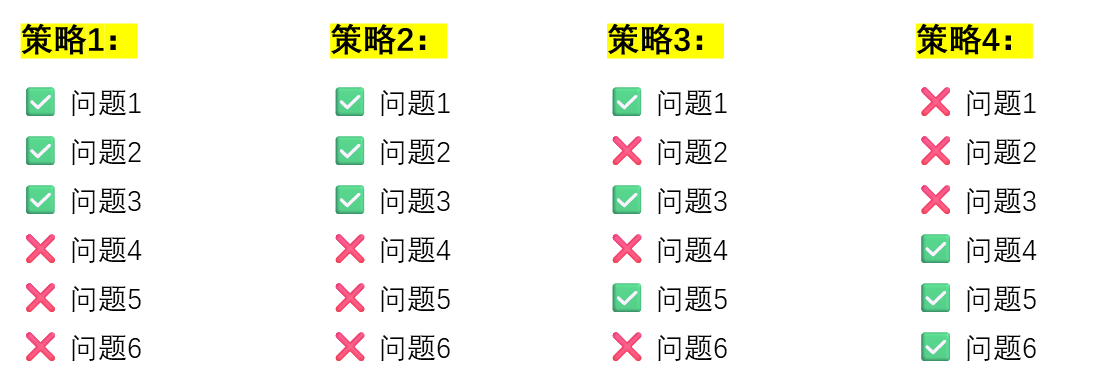

## 总结

本节教程主要讨论了提升 RAG 检索组件的召回率的几种方法。首先介绍了 RAG 系统的评测指标，包括检索组件的评测指标召回率和上下文相关性以及生成组件的评测指标忠诚度和答案相关性。然后针对提升 RAG 的检索组件指标提出了一系列方案，由 RAG 检索组件上游到下游的顺序，首先介绍了对用户查询进行重写的方法，包括扩写、同义词替换、历史信息插入以及子问题查询等常见方法；然后针对检索策略中的不同环节，分别介绍了节点组、文档表征方式以及多个相似度计算方法。在节点组部分介绍了基于分块的节点组构造方法以及基于语义提取的节点组构造方法，开发者可以针对不同任务，选择具体的方案进行节点组构造。在文本表征方式部分介绍了基于原文的表征和向量化表征，介绍了传统词袋模型、句子的向量化以及稀疏向量，介绍了基于向量化表征进行文档检索的流程。介绍了基于相似度函数进行检索的原理和内积、余弦相似度、bm25三种相似度函数。介绍了基于召回重排策略的两阶段检索方法，最终引出了多路召回RAG。虽然多路检索 RAG 可以通过提升检索组件的召回率从而提升 RAG 系统的效果，但其计算和存储开销相对较高，因此在设计时需要考虑减少冗余计算以及检索器的调度等问题。下一节课程我们将带大家一起学习如何提升RAG系统的性能问题。

## 参考文献

RAGAS：https://arxiv.org/pdf/2309.15217

bge-m3: https://arxiv.org/pdf/2402.03216